# **Section4 Project**

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import  pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import *
import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, BatchNormalization,\
                        Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from skimage.color import rgb2gray
from keras.regularizers import l2
from skimage.util import img_as_ubyte
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Input


# 1. 데이터확인

> age = { 1~116 } 나이를 나타냄

> ethnicity = { 0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Hispanic" } 인종을 나타냄

> gender = { 0: "Male", 1: "Female" } 성별을 나타냄

> img_name = { .jpg } 이미지 명을 나타냄

> pixels = { pixel } 이미지를 나타냄

데이터 로드 및 확인

In [2]:
df = pd.read_csv('/content/drive/MyDrive/data/Project4/project4_data.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


데이터 정보확인 및 전처리


In [3]:
#train 전처리를 위한 값 확인
print(df.shape)
print('--------------')
print(df.isnull().sum())
print('--------------')
print('중복값 :', df.duplicated().sum())
print('--------------')
print(df.dtypes)

(23705, 5)
--------------
age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64
--------------
중복값 : 0
--------------
age           int64
ethnicity     int64
gender        int64
img_name     object
pixels       object
dtype: object


의미없는 이미지 이름 삭제

In [4]:
df = df.drop("img_name",axis=1)

성별 데이터 그래프

 0: "Male", 1: "Female"

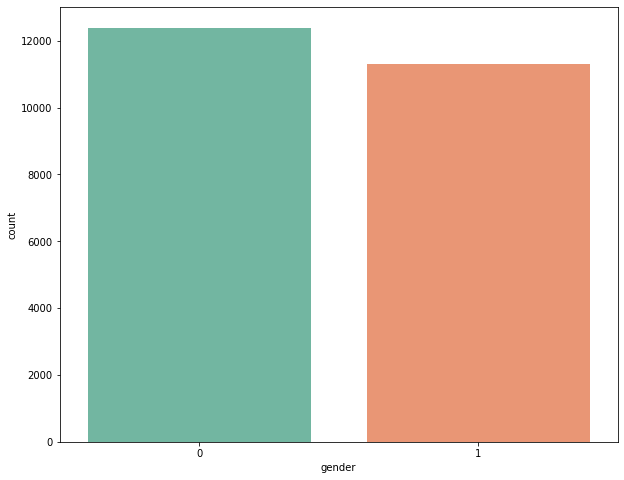

In [5]:
plt.figure(figsize=(10,8))
sns.set_palette("Set2")
sns.countplot(x ='gender', data = df)

나이별 데이터 그래프

In [6]:
print('age values: ', df['age'].nunique())
print(df['age'].unique()) #1~116

age values:  104
[  1  10 100 101 103 105  11 110 111 115 116  12  13  14  15  16  17  18
  19   2  20  21  22  23  24  25  26  27  28  29   3  30  31  32  33  34
  35  36  37  38  39   4  40  41  42  43  44  45  46  47  48  49   5  50
  51  52  53  54  55  56  57  58  59   6  60  61  62  63  64  65  66  67
  68  69   7  70  71  72  73  74  75  76  77  78  79   8  80  81  82  83
  84  85  86  87  88  89   9  90  91  92  93  95  96  99]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


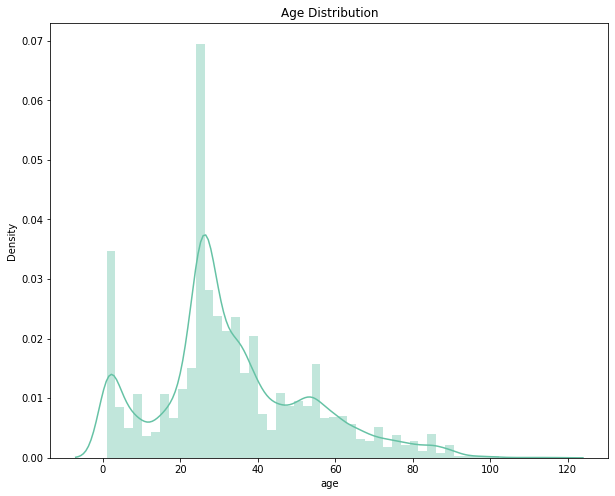

In [7]:
plt.figure(figsize=(10,8))
sns.distplot(df['age'])
plt.title('Age Distribution')
plt.show()

인종별 데이터 그래프

 0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Hispanic" 

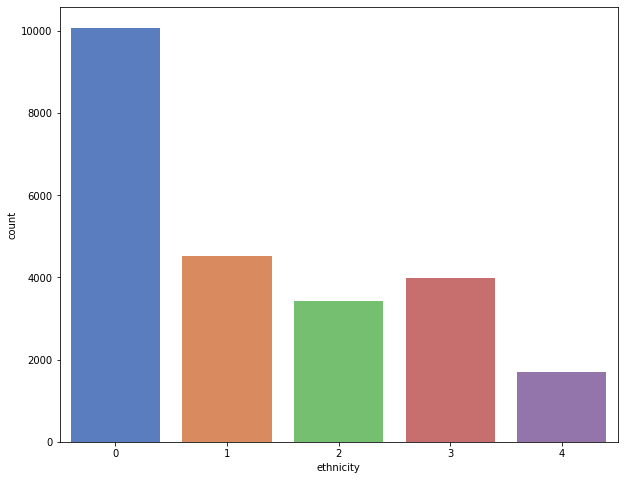

In [8]:
plt.figure(figsize=(10,8))
sns.set_palette("muted")
sns.countplot(x ='ethnicity', data = df) 

# 2. 모델링

In [9]:
#pixels 을 float으로 변경하고 
def values_to_array(pixels):
    arr=np.array(pixels.split(),'float64')
    arr=arr.reshape(48,48)

    return arr
df['pixels']=df['pixels'].apply(values_to_array)


In [10]:
#(48,48,1)로 변경
img_data = np.array(df['pixels'].tolist())
img_data = img_data.reshape(img_data.shape[0], 48,48,1)
size = len(img_data)

In [11]:
images = []
ages = []
genders = []
for idx, img in enumerate(img_data[:]):
    if(idx%5000==0):print(idx)
    image = img
    image = image.reshape((image.shape[0],image.shape[1]))
    images.append(image)
    ages.append(df['age'][idx])
    genders.append(df['gender'][idx])

0
5000
10000
15000
20000


In [13]:
def display(img):
    plt.imshow(img)
    plt.set_cmap('gray')
    plt.show()

def age_group(age):
    if age <= 1:
        return 0
    elif age <= 14:
        return 1
    elif age <= 44:
        return 2
    elif age <= 64:
        return 3
    else:
        return 4

def get_age(distr):
    distr = np.argmax(distr, axis=1)
    if distr == 0:
      return "<1"
    if distr == 1:
      return "1-14"
    if distr == 2:
      return "15-44"
    if distr == 3:
      return "45-64"
    if distr == 4:
      return "65>"
    else: 
      return "Unknown"

In [14]:
def get_gender(prob):
    prob = np.argmax(prob, axis=1)
    if prob == 0:
      return "Male"
    elif prob == 1:
      return "Female"

In [15]:
def get_result(sample):
    gray = rgb2gray(sample)
    norm = (gray-np.min(gray))/(np.max(gray)-np.min(gray))
    img8bit = img_as_ubyte(norm)
    val = model.predict(np.array([img8bit]))
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("\nPredicted Gender:",gender,"Predicted Age:",age)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0
5000
10000
15000
20000
Before


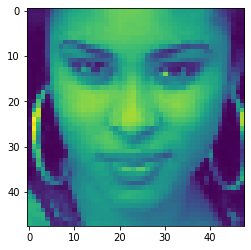

After grayscale


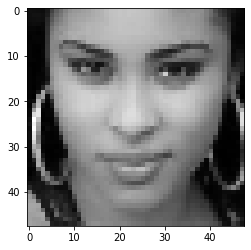

|  Age: 22


(23705, 48, 48, 1)

In [16]:
target = [[],[]]
features = np.zeros((size,48,48),dtype = 'float32')
for i in range(size):
    if(i%5000==0):print(i)
    target[0].append(age_group(int(ages[i]))) #age_group(int(ages[i])) / 5
    target[1].append(int(genders[i])) # target[i,1] = int(genders[i])
    gray = rgb2gray(images[i])
    norm = (gray-np.min(gray))/(np.max(gray)-np.min(gray))
    img8bit = img_as_ubyte(norm)
    features[i] = img8bit
print('Before')
imgplot = plt.imshow(images[3996])
plt.show()
# features = rgb2gray(features)
print('After grayscale')
display(features[3996])
print("|  Age:",ages[3996])

features = np.array([features])
features = features.reshape(size, 48, 48, 1)
features.shape

train / test 세트 분할

In [17]:
labels = np.array(target)
labels.reshape(size,2)

labels1 = tf.keras.utils.to_categorical(labels[0])
labels2 = tf.keras.utils.to_categorical(labels[1])
labels1 = np.array(labels1)
labels2 = np.array(labels2)

x_train, x_test, y_train, y_test = train_test_split(features, labels1, test_size=0.2, shuffle = True, random_state=1)
x_train2, x_test2, y_train2, y_test2 = train_test_split(features, labels2, test_size=0.2, shuffle = True, random_state=1)

print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18964
Samples in Testing: 4741


In [18]:
x_train.shape, x_test.shape

((18964, 48, 48, 1), (4741, 48, 48, 1))

콜백 함수

In [19]:
earlystop = EarlyStopping(
    monitor='loss', 
    mode='min',
    patience=20
    )

checkpoint= ModelCheckpoint(
    filepath='./',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
    )

모델링

In [20]:
#Model
inputs = Input(shape=(48,48,1))
conv1 = Conv2D(6, kernel_size=(3, 3),activation='relu',padding = 'same',
               strides=(1, 1),kernel_regularizer=l2(0.001))(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(12, kernel_size=(3, 3),activation='relu',padding = 'same',
               strides=(1, 1),kernel_regularizer=l2(0.001))(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(24, kernel_size=(3, 3),activation='relu',padding = 'same',
               strides=(1, 1),kernel_regularizer=l2(0.001))(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(48, kernel_size=(3, 3),activation='relu',padding = 'same',
               strides=(1, 1),kernel_regularizer=l2(0.001))(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(96, kernel_size=(3, 3),activation='relu',padding = 'same',
               strides=(1, 1),kernel_regularizer=l2(0.001))(pool4)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
x = Dropout(0.25)(pool5)
flat = Flatten()(x)

dropout = Dropout(0.25)

age_model = Dense(96, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(48, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(24, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(12, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(6, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(5, activation='sigmoid')(age_model)

gender_model = Dense(96, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(48, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(24, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(12, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(6, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(2, activation='sigmoid')(gender_model)

model = Model(inputs=inputs, outputs=[age_model, gender_model])



In [21]:
model.compile(optimizer = 'adam',
              loss =['mse','binary_crossentropy'],
              metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 6)    60          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 24, 6)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 12)   660         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [22]:
CNN_Model = model.fit(x_train,[y_train,y_train2],
                      validation_data=(x_test,[y_test,y_test2]),
                      callbacks = [earlystop, checkpoint],
                      shuffle = True,
                      batch_size=96,
                      epochs=10)


Epoch 1/10
198/198 [==============================] - 32s 150ms/step - loss: 0.9930 - dense_5_loss: 0.1811 - dense_11_loss: 0.7183 - dense_5_accuracy: 0.5121 - dense_5_precision: 0.3999 - dense_5_recall: 0.4908 - dense_11_accuracy: 0.5207 - dense_11_precision: 0.5189 - dense_11_recall: 0.4962 - val_loss: 0.8747 - val_dense_5_loss: 0.1212 - val_dense_11_loss: 0.6750 - val_dense_5_accuracy: 0.5971 - val_dense_5_precision: 0.5971 - val_dense_5_recall: 0.5971 - val_dense_11_accuracy: 0.6279 - val_dense_11_precision: 0.6259 - val_dense_11_recall: 0.6440
Epoch 2/10
198/198 [==============================] - 29s 147ms/step - loss: 0.8748 - dense_5_loss: 0.1418 - dense_11_loss: 0.6625 - dense_5_accuracy: 0.5674 - dense_5_precision: 0.5322 - dense_5_recall: 0.4891 - dense_11_accuracy: 0.5991 - dense_11_precision: 0.5868 - dense_11_recall: 0.6024 - val_loss: 0.7230 - val_dense_5_loss: 0.1165 - val_dense_11_loss: 0.5409 - val_dense_5_accuracy: 0.5971 - val_dense_5_precision: 0.5971 - val_dense_5_

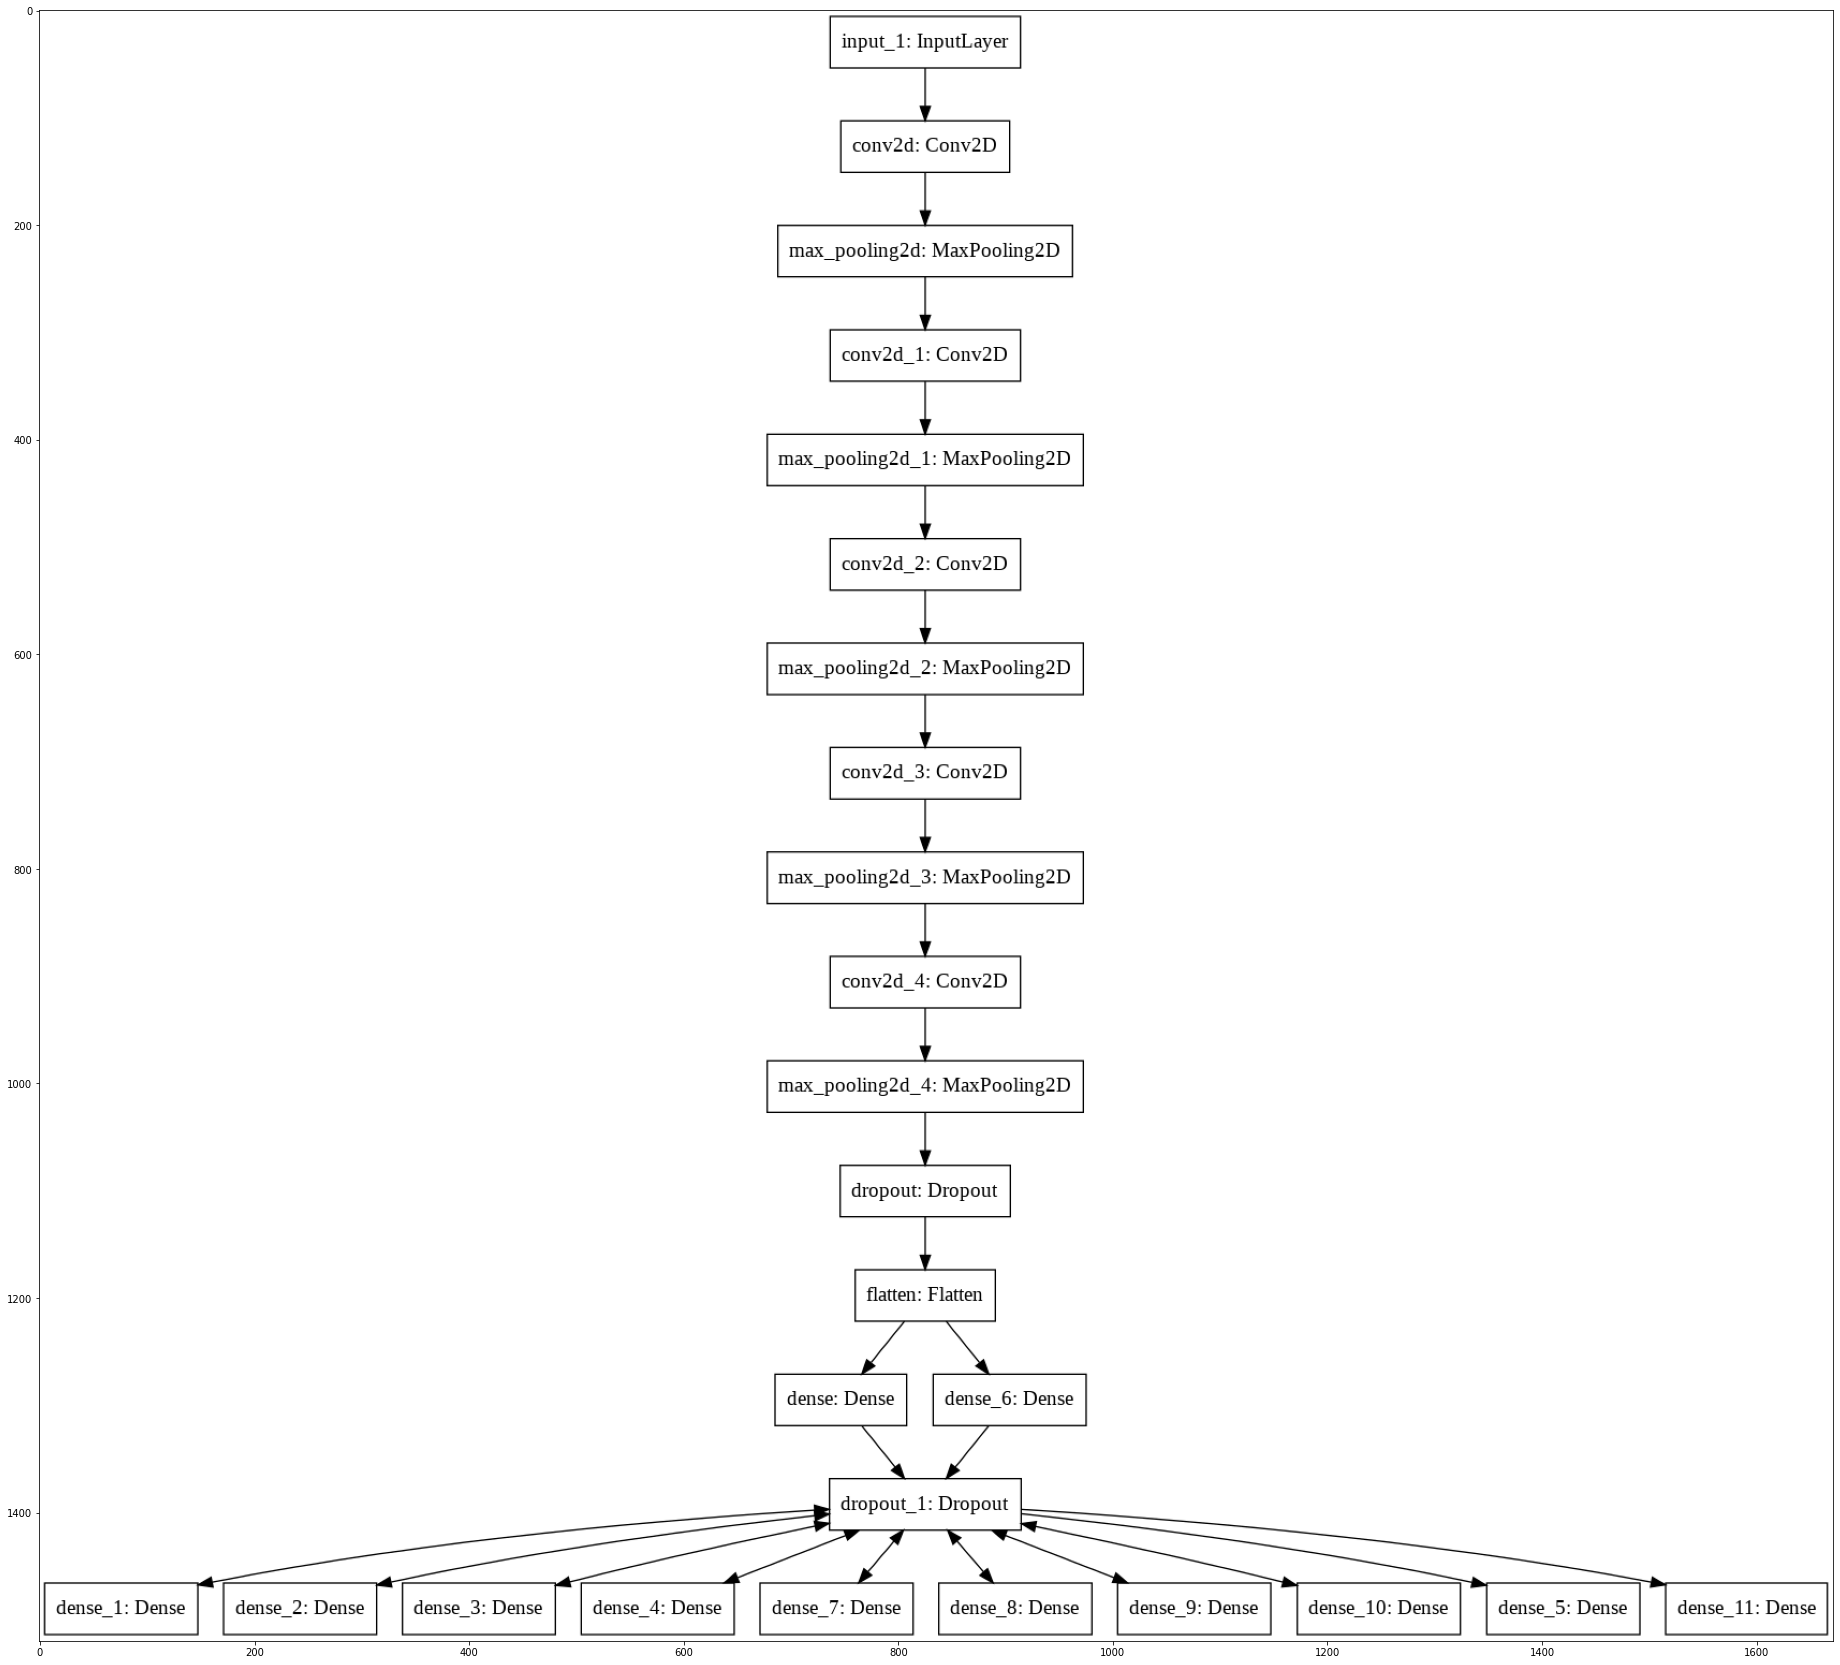

In [23]:
%matplotlib inline

tf.keras.utils.plot_model(model, to_file='model.png')
img = mpimg.imread('model.png')

plt.figure(figsize=(40, 30))
plt.imshow(img)

LOSS 및 ACCURACY 확인

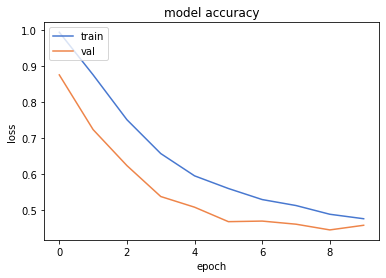

loss: 0.64%


In [27]:
history = CNN_Model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
loss = np.mean(history.history['loss'])
print("%s: %.2f%%" % ('loss',(loss)))

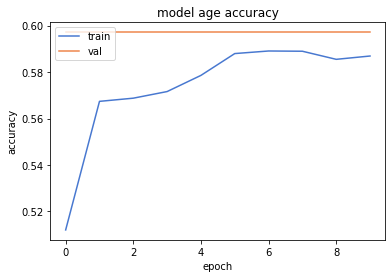

train_age_mean_accuracy: 57.37%
test_age_mean_accuracy: 59.71%


In [28]:
plt.plot(history.history['dense_5_accuracy'])
plt.plot(history.history['val_dense_5_accuracy'])
plt.title('model age accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

acc_train = np.mean(history.history['dense_5_accuracy'])
acc_test = np.mean(history.history['val_dense_5_accuracy'])
print("%s: %.2f%%" % ('train_age_mean_accuracy',(acc_train*100)))
print("%s: %.2f%%" % ('test_age_mean_accuracy',(acc_test*100)))

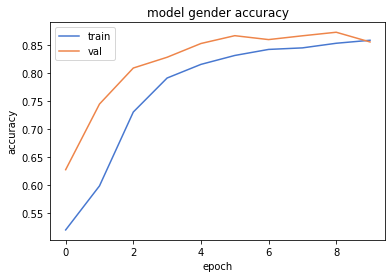

train_gender_mean_accuracy: 76.86%
test_gender_mean_accuracy: 81.82%


In [29]:
plt.plot(history.history['dense_11_accuracy'])
plt.plot(history.history['val_dense_11_accuracy'])
plt.title('model gender accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

acc_train = np.mean(history.history['dense_11_accuracy'])
acc_test = np.mean(history.history['val_dense_11_accuracy'])
print("%s: %.2f%%" % ('train_gender_mean_accuracy',(acc_train*100)))
print("%s: %.2f%%" % ('test_gender_mean_accuracy',(acc_test*100)))

classification_report

# 3. 모델 적용

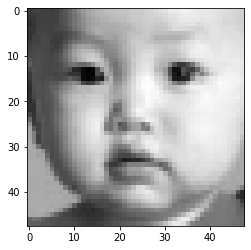

Age: 1

Predicted Gender: Male Predicted Age: 15-44


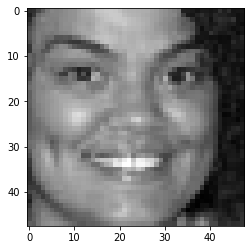

Age: 29

Predicted Gender: Female Predicted Age: 15-44


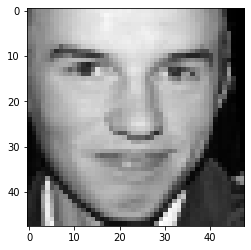

Age: 16

Predicted Gender: Male Predicted Age: 15-44


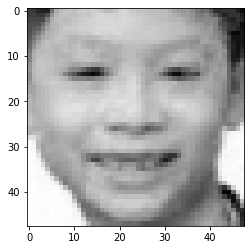

Age: 10

Predicted Gender: Male Predicted Age: 15-44


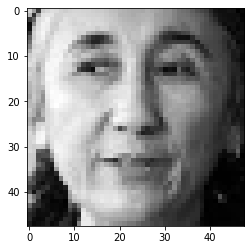

Age: 65

Predicted Gender: Female Predicted Age: 15-44


In [44]:
indexes = [2,9970,1945,1248,21240]

for idx in indexes:
  sample = images[idx]
  img = images[idx]
  imgplot = plt.imshow(img)
  plt.show()
  print("Age:",ages[idx])
  res = get_result(sample)

성별은 5개 모두 정확하지만 나이는 절반정도만 맞고 그나마 비슷하게 맞는정도이다.

In [39]:
#requirements.txt생성
pip freeze > requirements.txt

# 4. 결론 및 부족한점

정확도가 나이에서는 58% 성별에서는 80% 정도가 나왔고 그에 준하는 예측을 보여주었습니다. 처음 선정했던 데이터를 제대로 처리하지 못하고 급하게 데이터를 바꾸면서 많은 시간을 투자하지 못한것이 아쉽게 느껴집니다. 시간의 문제보다 제대로된 모델의 설계가 이루어지지 못하였고 다른 코드를 가져오기 급급한 수준의 능력부족이 가장 큰 문제였습니다. 
